In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import copy as cp
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, cross_val_predict 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score

from typing import Tuple

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_row", 160)
pd.set_option('max_colwidth', 200)

In [3]:
data = pd.read_csv('../../Data/20x43_D106015.csv')
data.head(5)

,loan_amnt,annual_inc,dti,fico_range_low,fico_range_high,int_rate,installment,open_acc,total_acc,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,mths_since_last_delinq,acc_now_delinq,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,pub_rec,months_cr_line,term,initial_list_status,sub_grade,emp_length,MORTGAGE,OWN,RENT,car,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,Not Verified,Source Verified,Verified,loan_status_bin
0,-1.710264,-0.170493,0.829172,-0.425785,-0.425785,-0.643790,-1.712281,-0.534592,0.045671,0.052599,0.324558,-0.938786,-0.475411,0.653234,-0.074813,-0.169192,-0.105946,-0.604541,-0.392733,-0.077399,-0.074813,0.902671,-1.424110,0.045419,-0.752901,-0.392652,0.990766,-0.169192,-0.312665,-0.885871,-0.271487,-0.114708,-0.215875,-0.185873,-0.19115,1.963633,-0.043113,-0.144338,-0.144338,1.296762,-0.758962,-0.595207,0.0
1,-0.220640,-0.022381,-0.004694,-0.713738,-0.713738,1.352522,-0.187752,0.281683,0.133276,-0.375976,-0.664238,-0.094035,-0.475411,1.318457,-0.074813,-0.169192,-0.105946,-0.601645,3.601285,0.605054,-0.074813,0.902671,0.702193,-1.568703,-0.752901,-0.392652,0.990766,-0.169192,-0.312665,-0.885871,3.683418,-0.114708,-0.215875,-0.185873,-0.19115,-0.509260,-0.043113,-0.144338,-0.144338,-0.771151,1.317589,-0.595207,1.0
2,-1.071854,0.240519,0.629044,-0.425785,-0.425785,1.352522,-1.051675,-0.738661,-1.005580,1.311539,1.802279,-0.938786,-0.475411,2.601388,-0.074813,-0.169192,-0.105946,-0.395169,-0.392733,2.930452,-0.074813,0.902671,0.702193,-0.223601,-0.752901,2.546784,-1.009320,-0.169192,-0.312665,-0.885871,-0.271487,-0.114708,-0.215875,-0.185873,-0.19115,1.963633,-0.043113,-0.144338,-0.144338,-0.771151,-0.758962,1.680088,0.0
3,-0.220640,0.014648,0.680359,0.150120,0.150120,1.352522,-0.187752,1.506095,0.746505,2.320996,0.561723,-0.938786,-0.475411,-0.914792,-0.074813,-0.169192,-0.105946,1.111594,-0.392733,-0.671386,-0.074813,-1.107823,0.702193,-0.223601,1.328195,-0.392652,-1.009320,-0.169192,-0.312665,-0.885871,-0.271487,-0.114708,-0.215875,5.380004,-0.19115,-0.509260,-0.043113,-0.144338,-0.144338,-0.771151,1.317589,-0.595207,0.0
4,-0.305762,-0.194784,1.090877,-0.425785,-0.425785,1.352522,-0.274111,1.506095,1.972965,-0.350852,-0.631400,0.750715,-0.475411,2.126228,-0.074813,-0.169192,0.113927,0.117630,-0.392733,-0.077399,-0.074813,0.902671,0.702193,-1.568703,-0.752901,2.546784,-1.009320,-0.169192,-0.312665,1.128832,-0.271487,-0.114708,-0.215875,-0.185873,-0.19115,-0.509260,-0.043113,-0.144338,-0.144338,-0.771151,-0.758962,1.680088,1.0


In [4]:
data.shape

(539, 43)

In [5]:
data.loan_status_bin.value_counts()
#0 = Defaulted Loans
#1 = Loans Paid In Full

1.0    461
0.0     78
Name: loan_status_bin, dtype: int64

In [6]:
X = data.drop('loan_status_bin', axis=1)
X.shape

(539, 42)

In [7]:
y = data['loan_status_bin']

In [8]:
lr1 = LogisticRegression()

In [9]:
steps = [('model', lr1)]
pipeline = Pipeline(steps=steps)

In [10]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.85185185 0.84259259 0.86111111 0.84259259 0.82242991]
0.8441156109380408


In [11]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[  2,  76],
       [  8, 453]])

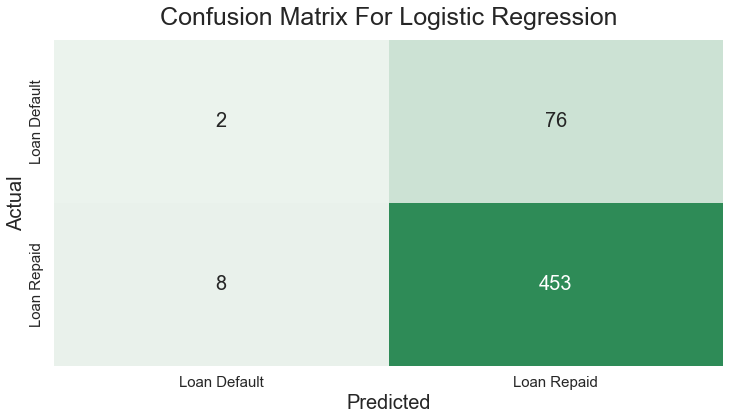

In [12]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [13]:
accuracy_score(y, y_pred)

0.8441558441558441

In [14]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

453
76
8
2
0.8441558441558441


In [15]:
#Re-examine original pool of accepted LC Loans: 

print(data.loan_status_bin.value_counts())
#0 = Loan Defaulted
#1 = Loan Fully Paid

good_loan = data.loan_status_bin.value_counts()[1]
bad_loan = data.loan_status_bin.value_counts()[0]

print()
print(good_loan / (good_loan + bad_loan))

#Random investment would give us 59% chance of pickkng a good loan

1.0    461
0.0     78
Name: loan_status_bin, dtype: int64

0.8552875695732839


In [16]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 0.1% better than Null Model or "random investment"
TP / (TP+FP)

0.8563327032136105

In [ ]:
#What if we "balance" the weight class to avoid "imbalanced" nature...No Change! 

In [25]:
lr_balanced = LogisticRegression(class_weight='balanced')

In [26]:
steps_balanced = [('model', lr_balanced)]
pipeline_balanced = Pipeline(steps=steps)

In [27]:
#Accuracy:

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
scores = cross_val_score(pipeline_balanced, X, y, scoring='accuracy', cv=cv, n_jobs=-1) 
print(scores)

score = np.mean(scores)
print(score)

[0.85185185 0.84259259 0.86111111 0.84259259 0.82242991]
0.8441156109380408


In [28]:
#Aggregated Confusion Matrix From RepeatedStratifiedKFold: 
y_pred_balanced = cross_val_predict(pipeline_balanced, X, y, cv=cv, n_jobs=-1)
conf_mat_balanced = confusion_matrix(y, y_pred_balanced)
conf_mat_balanced

array([[  2,  76],
       [  8, 453]])

In [17]:
#Obtain predicted probabilities (not predicted classes) from RSKF: 
y_pred_prob = cross_val_predict(pipeline, X, y, cv=cv, n_jobs=-1, method='predict_proba')

In [18]:
y_pred_prob

array([[0.1193962 , 0.8806038 ],
       [0.02223639, 0.97776361],
       [0.63516306, 0.36483694],
       ...,
       [0.10750942, 0.89249058],
       [0.1173953 , 0.8826047 ],
       [0.31499827, 0.68500173]])

In [19]:
#Obtaining classification based on desired threshold of 0.8: 

y_pred_success = (y_pred_prob[:, 1] > 0.8).astype('float')
y_pred_success

array([1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1.

In [20]:
conf_mat = confusion_matrix(y, y_pred_success)
conf_mat

array([[ 21,  57],
       [122, 339]])

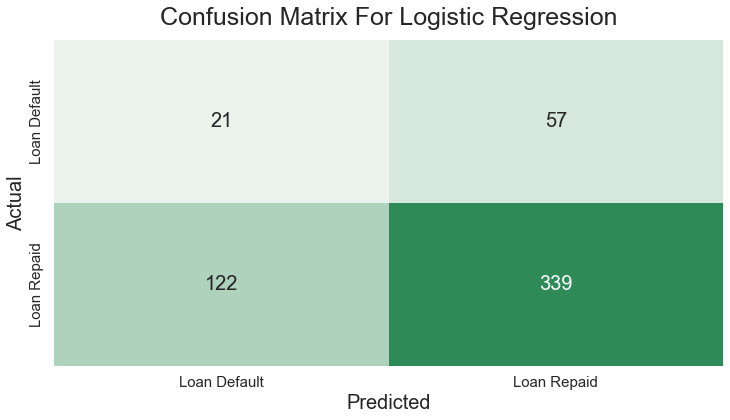

In [21]:
sns.set(rc = {'figure.figsize':(12,6)})
#cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
cmap = sns.light_palette('seagreen', as_cmap=True)

res = sns.heatmap(conf_mat, annot=True, fmt='d', annot_kws={"size":20},
#            xticklabels = ['Good = Paid In Full', 'Bad = Default'],
#            yticklabels = ['Loan Paid In Full', 'Bad = Default'], 
            cmap=cmap, cbar=False)

res.set_xticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)
res.set_yticklabels(['Loan Default', 'Loan Repaid'], fontsize=15)


plt.title('Confusion Matrix For Logistic Regression', fontsize=25, pad=15)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20);

In [22]:
accuracy_score(y, y_pred_success)

0.6679035250463822

In [23]:
TN, FP, FN, TP = conf_mat.ravel()
print(TP)
print(FP)
print(FN)
print(TN)
print((TP + TN) / (TN + TP + FP + FN))

339
57
122
21
0.6679035250463822


In [24]:
#Positive Predictive Value (or Precision)
#Logistic Model only does 3% better than Null Model or "random investment"
TP / (TP+FP)

0.8560606060606061

In [ ]:
## Next question. what was characteristic of the 217 loans that defaulted??
## Get all loans which you predicted greater than 80% and find out which ones defaulted.
## Any pattern?????

In [ ]:
#Do we drop all observations where the source is not verified? 
#Do we drop all observations loan amount is greater than half of one's income? 